In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import DataReader
from datetime import datetime
import scipy.stats as ss
import yfinance as yf
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)

In [3]:
# Preliminary Analysis 1
stock_symbol = "PANW"
stock_1 = yf.download(stock_symbol,start_date ,end_date)

# Discussion 1
adj_close = stock_1['Adj Close'].values
print('sample mean',np.mean(adj_close))
print('sample standard deviation',np.std(adj_close))
print('sample skewness: ',ss.skew(adj_close, axis=0, bias=True))
print('sample kurtosis: ',ss.kurtosis(adj_close, axis=0, bias=True) + 3)
print(stock_1.head())
print(stock_1['Adj Close'].describe()) # summary statistics

[*********************100%***********************]  1 of 1 completed

sample mean 175.56467342214242
sample standard deviation 78.6388706608656
sample skewness:  0.5515489943211344
sample kurtosis:  2.4906666224949117
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-01-02  77.746666  78.646667  77.650002  78.470001  78.470001  2835900
2020-01-03  77.646667  78.996666  77.646667  78.943336  78.943336  2229600
2020-01-06  78.783333  80.180000  78.570000  80.086670  80.086670  3342600
2020-01-07  80.086670  80.833336  79.776665  80.546669  80.546669  3384900
2020-01-08  79.333336  79.919998  78.926666  79.523331  79.523331  3157200
count    1174.000000
mean      175.564673
std        78.672384
min        44.193333
25%       117.724998
50%       167.468330
75%       227.447498
max       376.899994
Name: Adj Close, dtype: float64


/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_8177/3578420496.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stocks_by_month = stock_1.resample('M').mean()


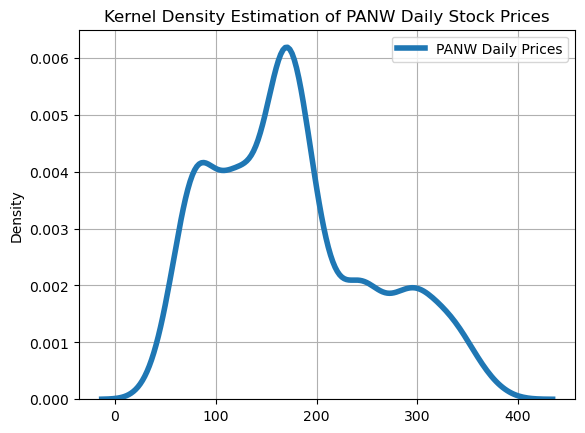

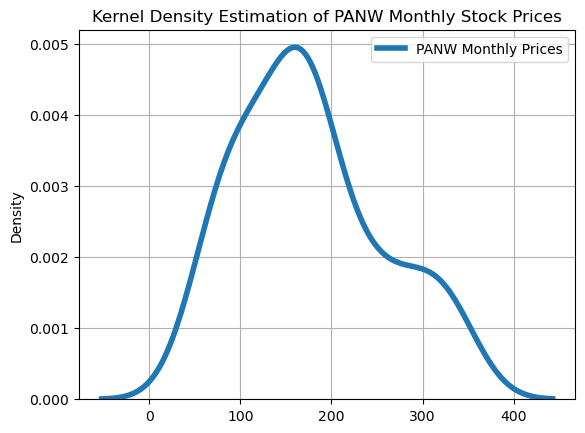

In [11]:
# Plot daily data KDE
plt.figure(1)
sns.kdeplot(data=adj_close, linewidth=4, label=f"{stock_symbol} Daily Prices")  # Add label for legend
plt.title(f"Kernel Density Estimation of {stock_symbol} Daily Stock Prices")  # Add plot title
plt.legend()  # Show the legend
plt.grid(True)  # Optional: add a grid for clarity


# Increase the data sampling frequency to monthly
stocks_by_month = stock_1.resample('M').mean()
stocks_monthly = stocks_by_month['Adj Close'].values

# Plot monthly data KDE
plt.figure(2)
sns.kdeplot(data=stocks_monthly, linewidth=4, label=f"{stock_symbol} Monthly Prices")  # Add label for legend
plt.title(f"Kernel Density Estimation of {stock_symbol} Monthly Stock Prices")  # Add plot title
plt.legend()  # Show the legend
plt.grid(True)  # Optional: add a grid for clarity
stocks_by_month['Adj Close'].describe()

# Show both plots
plt.show()

In [5]:
"Bootstrap"
T= adj_close.shape[0]
B = 1000 # 5000, 100000 [250 9750]
mu_boot = np.zeros(B)
se_boot = np.zeros(B)
x_boot_std = np.zeros(B)
for i in range(0, B):
     x_boot = adj_close[np.random.choice(T,T)]
     mu_boot[i] = np.mean(x_boot)
     se_boot[i] = np.std(x_boot)/np.sqrt(T) # std of mu_boot
     x_boot_std[i] = np.std(x_boot) # std of x_boot
     # CLT: std(x_boost) = sqrt(T)*std(mu_boot)
mu_boot = np.sort(mu_boot)
se_boot = np.sort(se_boot)
xboot_std = np.sort(x_boot_std)
print("Statistics about the Mean")
print("95% confidence interval of mu_boot:", mu_boot[25], mu_boot[975])
print("95% confidence interval of std_boot of mu :", se_boot[25], se_boot[975])
print("\n")
print("Statistics about the Sample")
print(f"95% confidence interval of {stock_symbol} stock price std (method 1):", se_boot[25]*np.sqrt(T), se_boot[975]*np.sqrt(T))
print(f"95% confidence interval of {stock_symbol} stock price std (method 2):", xboot_std[25], xboot_std[975])

Statistics about the Mean
95% confidence interval of mu_boot: 171.12223168979105 180.21982127032044
95% confidence interval of std_boot of mu : 2.2162232912886304 2.372372821325887


Statistics about the Sample
95% confidence interval of PANW stock price std (method 1): 75.93597319203953 81.28623125198627
95% confidence interval of PANW stock price std (method 2): 75.93597319203954 81.28623125198627


sample mean: $175.56467342214242
sample standard deviation: $78.6388706608656


/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_8177/3748246232.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulatedPrice[t] = p1*(u<p)+p2*(u>=p);


confidence interval of mu_mc: 163.6794364144587 173.81345788196094


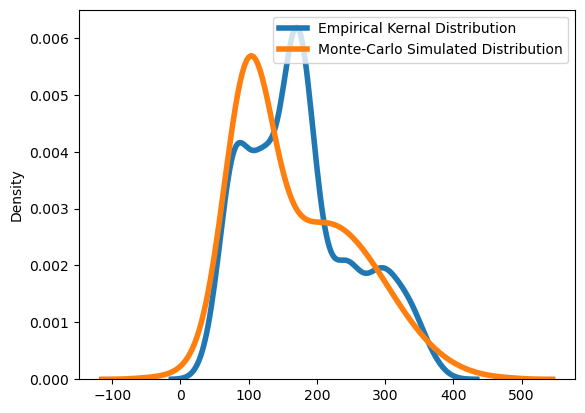

In [6]:
T = len(adj_close) # number of trading days
mu = np.mean(adj_close)
se = np.std(adj_close)
print(f"sample mean: ${mu}")
print(f"sample standard deviation: ${se}")

# observe kde plot and assign values to key parameters
mu_1 = 99# mean of the first component distribution
sigma_1 = 28 # standard deviation of the first component distribution
mu_2 = 215 # mean of the second component distribution
sigma_2 = 85 # standard deviation of the second component distribution
p = 0.4

def generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T):
    #Normal Mixture
    simulatedPrice = np.zeros(T-1);
    for t in range(0,T-1):
        p1 = mu_1 + sigma_1*np.random.normal(0,1,1);
        p2 = mu_2 + sigma_2*np.random.normal(0,1,1);
        u = np.random.uniform(0,1,1);
        simulatedPrice[t] = p1*(u<p)+p2*(u>=p);

    return simulatedPrice


T = adj_close.shape[0]
M = 1000
mu_mc = np.zeros(M)
y_mc = 0
for i in range(0, M):
    simulatedPrice = generateEmpiricalDist(mu_1, sigma_1, mu_2, sigma_2, p, T)
    mu_mc[i] = np.mean(simulatedPrice)
    y_mc += np.sort(simulatedPrice)

y_mc = y_mc/M
mu_mc = np.sort(mu_mc)

print("confidence interval of mu_mc:", mu_mc[25], mu_mc[975])

# Visualization
fig, ax = plt.subplots()
sns.kdeplot(data=adj_close, linewidth=4) # the blue line
sns.kdeplot(data=y_mc, linewidth=4) # the orange line
ax.legend(['Empirical Kernal Distribution', 'Monte-Carlo Simulated Distribution'])

/var/folders/p3/rcvq04y148z9r_2p528s4znc0000gn/T/ipykernel_8177/4273315190.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r[t] = r1*(u <= p)+r2*(u > p)


<Figure size 1000x600 with 0 Axes>

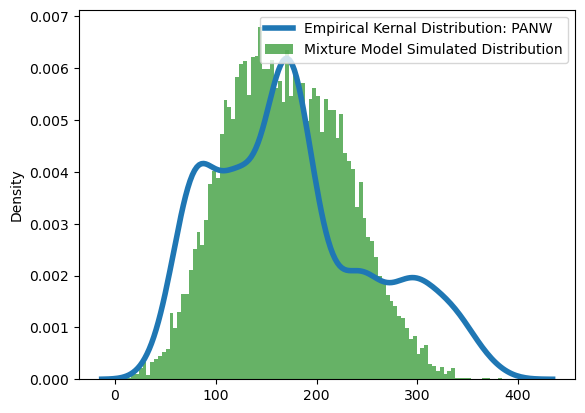

In [8]:

# Given parameters
mu_1 = 130
sigma1 = 40
mu_2 = 210
sigma2 = 45
p = 0.5
T = 10000

# Generate the data for r
r = np.zeros(T)
for t in range(T):
    eps1 = np.random.normal(0,1,1)
    eps2 = np.random.normal(0,1,1)
    r1 = mu_1 + sigma1 * eps1
    r2 = mu_2 + sigma2 * eps2
    u = np.random.uniform(0,1,1)
    r[t] = r1*(u <= p)+r2*(u > p)

# Plotting the histogram of r
plt.figure(figsize=(10,6))
fig, ax = plt.subplots()
sns.kdeplot(data=adj_close, linewidth=4)
plt.hist(r, bins=100, density=True, alpha=0.6, color='green', label="Histogram")
ax.legend([f'Empirical Kernal Distribution: {stock_symbol}', 'Mixture Model Simulated Distribution'])